# CCD Response Measurements

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os.path

In [3]:
import scipy.stats

In [4]:
import astropy.io.fits as fits

## Model

Given some CCD images captured under varying exposure times with illumination is that is roughly constant in time and flat over the image, we wish to estimate the basic CCD response parameters:
 - pedestal $y_0$ is the mean response in ADU with no signal, due to bias offsets in the output stage.
 - read noise $\sigma_r$ is the RMS noise injected by the output stage.
 - (inverse) gain $g$ in e/ADU is the output stage conversion from ADU to detected electrons.
 - dark current $i_d$ in e/s is the mean current sourced by each pixel under bias, expected to be temperature dependent.
 
The conditions for each image are described by:
 - illumination current $i_f$ in e/s is the mean photocurrent due to the CCD illumination.
 - exposure time $\Delta t$ in s is the shutter open time.

The expected per-pixel CCD response in ADU is Gaussian with a mean and variance
$$
\begin{aligned}
\mu &= (i_d + i_f) \Delta t / g + y_0 \\
\sigma^2 &= (\mu - y_0) / g + \sigma_r^2 \; .
\end{aligned}
$$

The corresponding pixel signal-to-noise ratio $\nu$ is:
$$
\nu = \frac{i_f \Delta t}{\sqrt{(i_d + i_f)\Delta t + g^2 \sigma_r^2}} \; .
$$

In [5]:
def model(dt, y0, sigr, gain, current):
    """Calculate predicted mean and variance given model inputs.
    """
    mu = current * dt / gain + y0
    var = (mu - y0) / gain + sigr ** 2
    return mu, var

## Methods

The simplest method involves taking unweighted averages of different subsets of exposures:
 1. Use "bias" exposures with $\Delta t = 0$ to estimate the pedestal and readnoise, both in ADU:
$$
y_0 \simeq \langle \mu_i\rangle_{\Delta t = 0} \quad , \quad
\sigma_r^2 \simeq \langle\sigma^2_i\rangle_{\Delta t = 0} \; .
$$
 2. Use pairs $(i,j)$ of images with different exposure times, $\Delta t_i < \Delta t_j$, but the same illumination ($i_f$) and temperature ($i_d$) to estimate the gain:
$$
g \simeq \left\langle \frac{\mu_j - \mu_i}{\sigma^2_j - \sigma^2_i}\right\rangle_{\Delta t_i < \Delta t_j} \; .
$$
Note that the exposure times do not need to be known precisely for the gain measurement, although larger differences will provide more accurate estimates.
 3. Finally, estimate the combined current in ADU/s using:
$$
\frac{i_d + i_f}{g} \simeq \left\langle \frac{\mu_j - \mu_i}{\Delta t_j - \Delta t_i}\right\rangle_{\Delta t_i < \Delta t_j} \; .
$$
Use "dark" exposures with the shutter closed to set $i_f = 0$ and measure the dark current $i_d$ independently.

In [6]:
def measure_with_averages(mu, var, dt, converted=True, verbose=True):
    mu = np.asarray(mu).ravel()
    var = np.asarray(var).ravel()
    dt = np.asarray(dt).ravel()
    # Select bias exposures.
    bias = (dt == 0)
    # Estimate the pedestal and read noise.
    y0 = np.mean(mu[bias])
    sigr = np.sqrt(np.mean(var[bias]))
    # Identify pairs (i,j) of exposures with dt[i] < dt[j].
    i, j = np.where(dt.reshape(-1, 1) < dt)
    # Estimate inverse gain in e/ADU.
    gain = np.mean((mu[j] - mu[i]) / (var[j] - var[i]))
    # Estimate the total current in ADU.
    current = np.mean((mu[j] - mu[i]) / (dt[j] - dt[i]))
    if verbose:
        print(f'   pedestal: {y0:.3f} ADU = {y0 * gain:.3f} e')
        print(f'  readnoise: {sigr:.3f} ADU = {sigr * gain:.3f} e')
        print(f'       gain: {gain:.4f} e/ADU')
        print(f'    current: {current:.2f} ADU/s = {current * gain:.2f} e/s')
    if converted:
        # Convert y0, sigr, current from ADU to e.
        y0 *= gain
        sigr *= gain
        current *= gain
    return y0, sigr, gain, current

To improve upon this method, we can assign statistical uncertainties to the estimated $\mu_i$ and $\sigma_i$ values to use for more optimal weighting, to estimate uncertainties on the CCD parameters, and to test the consistentcy of the data with the model.

Assuming that the following unbiased estimators are used:
$$
\mu_\text{est} \equiv \frac{1}{N} \sum_{i=1}^N x_i \quad , \quad
\sigma^2_\text{est} \equiv \frac{N}{N-1} \left[ \frac{1}{N} \sum_{i=1}^N x_i^2 - \mu_\text{est}^2\right] \; ,
$$
with $N$ samples $x_i$ that are independent and drawn from the same Gaussian distribution with true $\mu$ and $\sigma^2$, the corresponding estimator uncertainties are:
$$
\text{Var}(\mu_\text{est}) = \frac{\sigma^2}{N} \quad , \quad
\text{Var}(\sigma^2_\text{est}) = \frac{2\sigma^4}{N-1} \quad, \quad
\text{Cov}(\mu_\text{est},\sigma^2_\text{est}) = 0 \; .
$$

In [7]:
def uncertainties(mu, var, npix):
    """Estimate uncertainties in means and variances."""
    return var / npix, 2 * var ** 2 / (npix - 1)

## Data

The data was recorded with an [SBIG STXL-6303e camera](http://diffractionlimited.com/product/stxl-6303e/) which is being used in the DESI commissioning instrument and for the DESI sky fiber camera.

Extract images from individual `.fits.fz` files provided by Ashley Ross from the OSU test stand, and store in a single multi-HDU uncompressed file. Each image is described by three parameters:
 - Bn: nxn binning in the CCD readout.
 - Sn: set 1 or set 2. Both sets are equivalent, so just increase the statistics.
 - Nn: exposure 1-8 with:
   - n=1,2: bias frame with $\Delta t = 0$s.
   - n=3,4: bias frame with $\Delta t = 1$s.
   - n=4,5: bias frame with $\Delta t = 3$s.
   - n=6,7: bias frame with $\Delta t = 5$s.

Output HDU names are the concatenation of these three tags, e.g., `B2S1N7` for 2x2 binning, set 1, exposure 7 (5s).

In [8]:
def extract():
    out = fits.HDUList()
    out.append(fits.PrimaryHDU())
    for binned in True, False:
        for set in (1, 2):
            for idx in range(1, 9):
                tag = f'B{"2" if binned else "1"}S{set}N{idx}'
                path = f'FORDK_{"BIN" if binned else ""}set{set}'
                if not os.path.exists(path):
                    print('Missing input data.')
                    return
                name = f'FORDK_{"BIN" if binned else "NOBIN"}-{idx:08d}.fits.fz'
                with fits.open(os.path.join(path, name)) as hdus:
                    data = hdus['CIN'].data
                out.append(fits.ImageHDU(data, name=tag))
    out.writeto('sbig.fits', overwrite=True)

In [9]:
if not os.path.exists('sbig.fits'):
    extract()

Open the combined file:

In [10]:
hdus = fits.open('sbig.fits')

Each exposure has the same illumination but it varies over the image, so we extract a small central region for calculating the Gaussian mean and variance statistics:

In [11]:
def extract_central(data, fraction=0.1, return_rect=False):
    height, width = data.shape
    window_width = int(round(fraction * width))
    window_height = int(round(fraction * height))
    xlo = (width - window_width) // 2
    xhi = xlo + window_width
    ylo = (height - window_height) // 2
    yhi = ylo + window_height
    central = data[ylo:yhi, xlo:xhi]
    return (central, (xlo, ylo), window_width, window_height) if return_rect else central

In [12]:
def plot_exposure(which, hdus=hdus, maxbins=500):

    data = hdus[which].data
    central, xy, w, h = extract_central(data, return_rect=True)
    mu, std = np.mean(central), np.std(central)
    # Use downsampled integer binning to avoid artifacts.
    ilo, ihi = np.percentile(data.ravel(), (0, 99.99)).astype(int)
    binsize = int(np.ceil((ihi - ilo + 1.) / maxbins))
    nbins = int(np.ceil((ihi - ilo) / binsize))
    ihi = ilo + nbins * binsize
    lo, hi = ilo - 0.5, ihi + 0.5
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].hist(data.ravel(), range=(lo, hi), bins=nbins, color='r')
    ax[0].hist(central.ravel(), range=(lo, hi), bins=nbins, color='k')
    ax[0].set_yscale('log')
    ax[0].set_xlabel('ADU')
    ax[0].set_xlim(lo, hi)
    ax[0].axvline(mu, color='w', lw=2, alpha=0.5)
    s = f'{which}: $\mu=${mu:.1f} $\sigma=${std:.2f}'
    ax[0].text(0.04, 0.94, s, transform=ax[0].transAxes, fontsize='large')
    lo, hi = np.percentile(data, (2.5, 99.5))
    ax[1].imshow(data, interpolation='none', cmap='plasma', vmin=lo, vmax=hi, aspect='auto')
    ax[1].axis('off')
    ax[1].add_artist(plt.Rectangle(xy, w, h, ec='k', lw=2, fc='none'))
    plt.tight_layout()

Bias exposure with 1x1 binning:

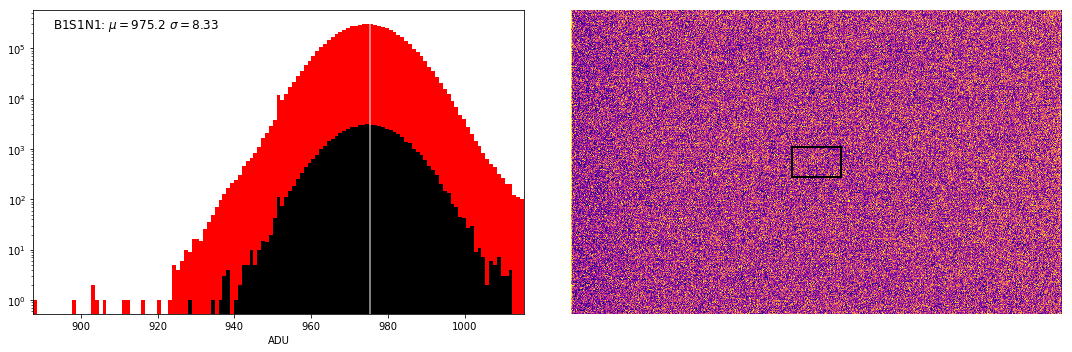

In [13]:
plot_exposure('B1S1N1')

Bias exposure with 2x2 binning:

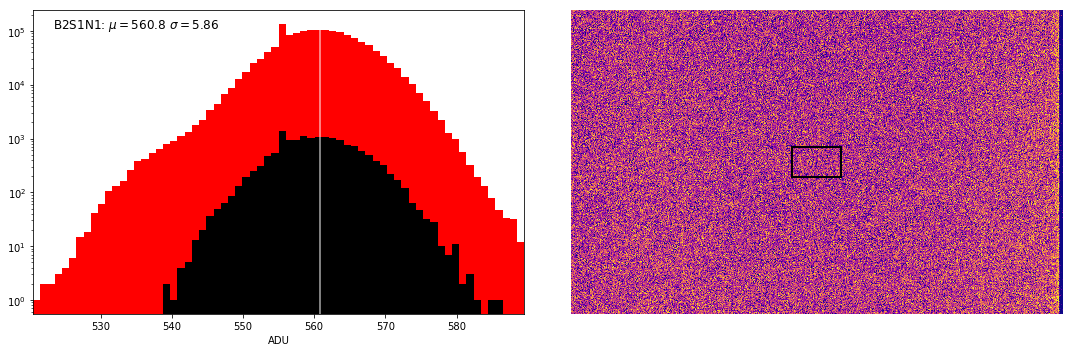

In [14]:
plot_exposure('B2S1N1')

5s flat with 1x1 binning:

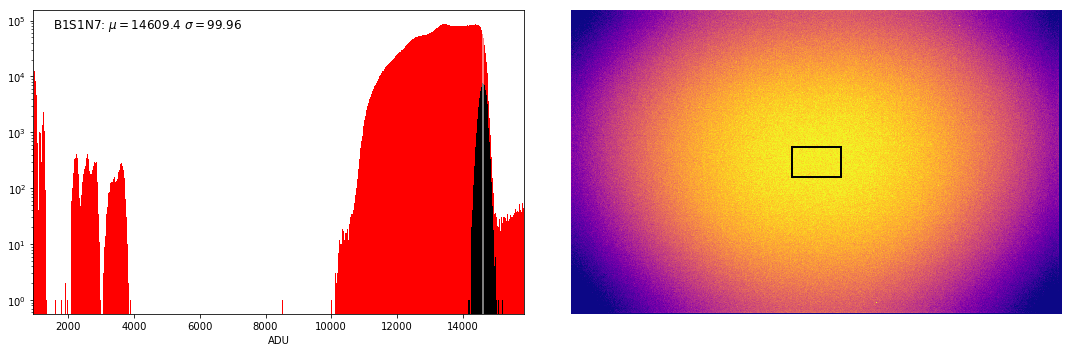

In [15]:
plot_exposure('B1S1N7')

5s flat with 2x2 binning:

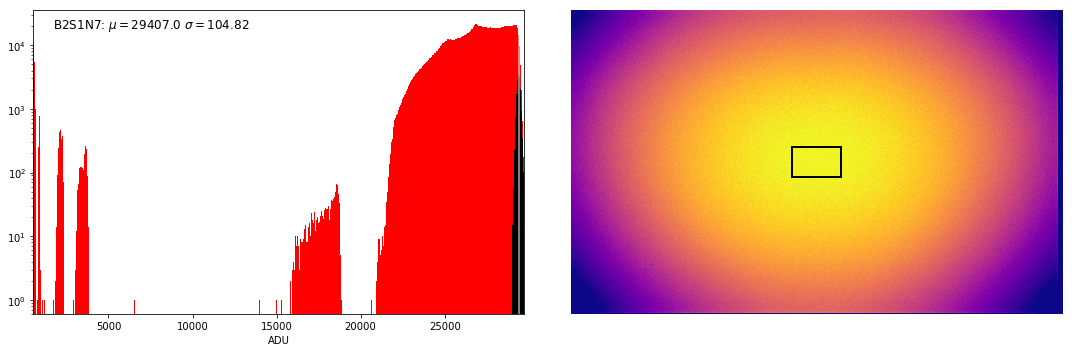

In [16]:
plot_exposure('B2S1N7', maxbins=500)

Estimate CCD response parameters for all 1x1 and 2x2 images:

Binning 1x1:
   pedestal: 974.733 ADU = 1388.837 e
  readnoise: 8.268 ADU = 11.780 e
       gain: 1.4248 e/ADU
    current: 2684.41 ADU/s = 3824.85 e/s
Binning 2x2:
   pedestal: 560.803 ADU = 1522.943 e
  readnoise: 5.871 ADU = 15.944 e
       gain: 2.7156 e/ADU
    current: 5967.03 ADU/s = 16204.36 e/s


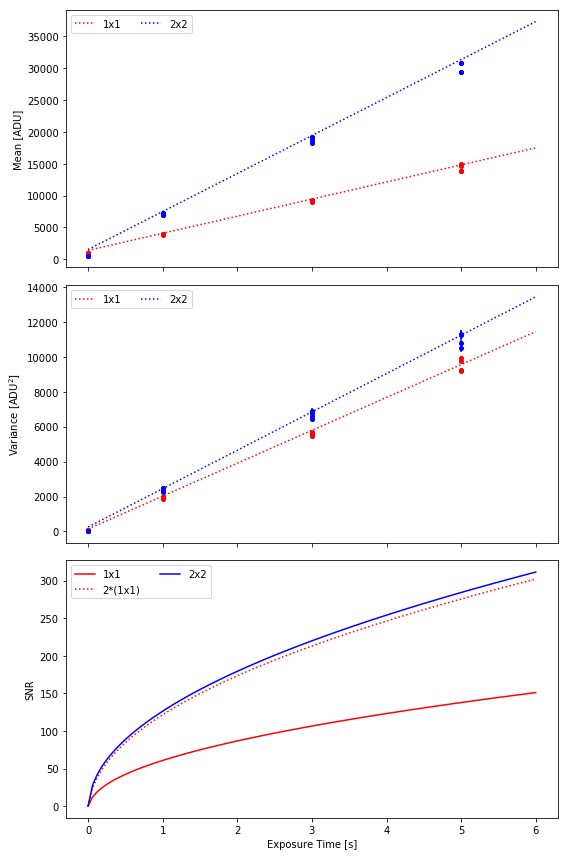

In [17]:
def analyze(hdus=hdus, fraction=0.05, clip_sigmas=5):

    # Exposure times in seconds for the images with each binning.
    dt = np.tile(np.repeat((0., 1., 3., 5.), 2), (2, 1))

    # Calculate Gausssian statistics for a small window at the center of each image.
    mu = np.empty((2, 2, 8))
    var = np.empty((2, 2, 8))
    npix = np.empty((2, 2, 8), int)
    for i, binned in enumerate((False, True)):
        for j, set in enumerate((1, 2)):
            for k, idx in enumerate(range(1, 9)):
                tag = f'B{"2" if binned else "1"}S{set}N{idx}'
                window = extract_central(hdus[tag].data, fraction=fraction)
                if clip_sigmas:
                    window, _, _ = scipy.stats.sigmaclip(window.ravel(), clip_sigmas, clip_sigmas)
                mu[i, j, k] = np.mean(window)
                var[i, j, k] = np.var(window, ddof=1)
                npix[i, j, k] = window.size
    mu_var, var_var = uncertainties(mu, var, npix)

    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 12))
    dt_pred = np.linspace(0, 1.2 * np.max(dt), 100)
    
    # Analyze 1x1 and 2x2 binning separately.
    for i, binning in enumerate(('1x1', '2x2')):
        c = 'rb'[i]
        print(f'Binning {binning}:')
        y0, sigr, gain, current = measure_with_averages(mu[i], var[i], dt, verbose=True)
        mu_pred, var_pred = model(dt_pred, y0, sigr, gain, current)
        
        # Calculate SNR assuming i_d << i_f.
        sig = current * dt_pred
        snr = sig / np.sqrt(sig + sigr ** 2)
        
        ax[0].plot(dt_pred, mu_pred, ':', c=c, label=binning)
        ax[1].plot(dt_pred, var_pred, ':', c=c, label=binning)
        ax[0].errorbar(dt.flatten(), mu[i].flatten(), np.sqrt(mu_var[i].flatten()),
                       fmt='o', c=c, markersize=4)
        ax[1].errorbar(dt.flatten(), var[i].flatten(), np.sqrt(var_var[i].flatten()),
                       fmt='o', c=c, markersize=4)
        ax[2].plot(dt_pred, snr, '-', c=c, label=binning)
        if binning == '1x1':
            ax[2].plot(dt_pred, 2 * snr, ':', c=c, label='2*(1x1)')

    ax[2].set_xlabel('Exposure Time [s]')
    ax[0].set_ylabel('Mean [ADU]')
    ax[1].set_ylabel('Variance [ADU$^2$]')
    ax[2].set_ylabel('SNR')
    ax[0].legend(loc='upper left', ncol=2)
    ax[1].legend(loc='upper left', ncol=2)
    ax[2].legend(loc='upper left', ncol=2)
    plt.tight_layout()
    plt.savefig('bining.png')

analyze()

The SNR with 2x2 binning is double the 1x1 SNR, as expected.